In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import matplotlib.animation as animation
import glob, re

import scienceplots
plt.style.use('default')
plt.style.use(['science', 'high-vis', 'grid'])

In [3]:
# Get lastly created folder in a directory
def get_last_folder(dir):
    list_of_subfolders = [f.path for f in os.scandir(dir) if f.is_dir()]
    latest_subfolder = max(list_of_subfolders, key=os.path.getmtime)
    return latest_subfolder

In [4]:
PSO_DIR = get_last_folder("../build/results_pso/")
DIR = PSO_DIR
part_files = glob.glob(DIR + "/part*.csv")
part_files.sort(key=lambda f: int(re.sub('\D', '', f)))

print(f"Found {len(part_files)} files")

Found 16 files


In [5]:
NbPart = len(part_files)
Data0 = np.loadtxt(part_files[0], delimiter=',', skiprows=1)
print(Data0.shape)
# Data is iter, x0, x1, ..., xN, v0, v1, ..., vN, best_x0, best_x1, ..., best_xN, best_f
Dim = int((Data0.shape[1] - 2) / 3)
NbIter = Data0.shape[0]
print(f"Dimension: {Dim}, NbIter: {NbIter}")

NB_PART = len(part_files)
NbPart = NB_PART
part_files = part_files[:NB_PART]

X = np.zeros((NbIter, NbPart, Dim))
V = np.zeros((NbIter, NbPart, Dim))
BestX = np.zeros((NbIter, NbPart, Dim))
BestF = np.zeros((NbIter, NbPart))

for i, f in enumerate(part_files):
    Data = np.loadtxt(f, delimiter=',', skiprows=1)
    X[:,i,:] = Data[:,1:Dim+1]
    V[:,i,:] = Data[:,Dim+1:2*Dim+1]
    BestX[:,i,:] = Data[:,2*Dim+1:3*Dim+1]
    BestF[:,i] = Data[:,3*Dim+1]

    

(152, 32)
Dimension: 10, NbIter: 152


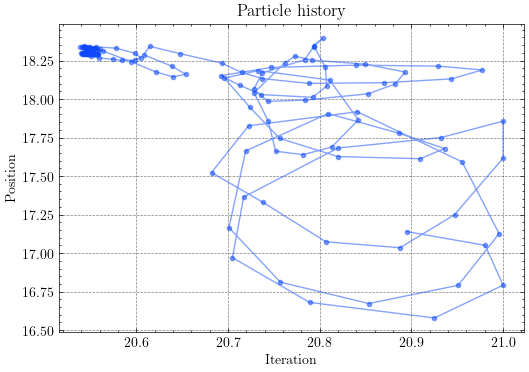

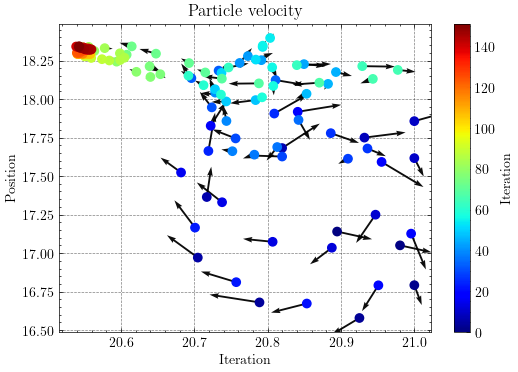

In [6]:
# Plot the history of the first particle
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_xlabel("Iteration")
ax.set_ylabel("Position")
ax.set_title("Particle history")
ax.plot(X[:,0,1], X[:,0,2], '.-', alpha=0.5, label="Position")

iters = np.arange(NbIter)
# Quiver plot of the velocity of the first particle
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_xlabel("Iteration")
ax.set_ylabel("Position")
ax.set_title("Particle velocity")
ax.quiver(X[:,0,1], X[:,0,2], V[:,0,1], V[:,0,2], alpha=0.95, label="Velocity", scale=10, scale_units='xy', angles='xy', width=0.005)
sc = ax.scatter(X[:,0,1], X[:,0,2], alpha=0.995, label="Position", c=iters, cmap='jet')
fig.colorbar(sc, label="Iteration")


In [7]:
# %matplotlib qt

# # Same in 3D
# fig = plt.figure(figsize=(6, 4))
# ax = fig.add_subplot(111, projection='3d')
# PosX = X[:,0,0]
# PosY = X[:,0,1]
# PosZ = X[:,0,2]
# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# ax.set_title("Particle history")
# ax.plot(PosX, PosY, PosZ, '.-', alpha=0.5, label="Position")

# # Quiver plot of the velocity of the first particle
# fig = plt.figure(figsize=(6, 4))
# ax = fig.add_subplot(111, projection='3d')
# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# ax.set_title("Particle velocity")
# ax.quiver(PosX, PosY, PosZ, V[:,0,0], V[:,0,1], V[:,0,2], length=0.1, normalize=True)

# colors = np.linspace(0, 1, NbIter)
# ax.scatter(PosX, PosY, PosZ, alpha=0.5, label="Position", c=colors, cmap='viridis')

# %matplotlib inline

In [8]:
def x_acc2(length_donor, Nx, xmax):
    # x = np.geomspace(length_donor, xmax, Nx)
    x = np.linspace(length_donor, xmax, Nx)
    return x

def x_acc(length_donor, nb_points_acceptor, total_length):
    dx_fine = 0.25
    size_fine_area = 1.0
    x_acceptor = np.zeros(nb_points_acceptor)
    x_acceptor[0] = length_donor
    i = 1
    while x_acceptor[i - 1] < length_donor + size_fine_area:
        x_acceptor[i] = x_acceptor[i - 1] + dx_fine
        i += 1
    dx_coarse = (total_length - length_donor - size_fine_area) / (nb_points_acceptor - i)
    while i < nb_points_acceptor:
        x_acceptor[i] = x_acceptor[i - 1] + dx_coarse
        i += 1
    return x_acceptor

# This function link points by exponential interpolation
def exp_link_points(xA, yA, xB, yB):
    alpha = (np.log(yB) - np.log(yA)) / (xB - xA)
    beta = yB / np.exp(alpha * xB)
    return alpha, beta 

def draw_line_exp(x0, xf, slope, intercept, ax):
    x = np.linspace(x0, xf, 100)
    y = intercept * np.exp(slope * x)
    plt.plot(x, y)

def draw_exp_links(ax, x, y):
    for i in range(len(x) - 1):
        alpha, beta = exp_link_points(x[i], y[i], x[i+1], y[i+1])
        draw_line_exp(x[i], x[i+1], alpha, beta, ax)
        

def plot_doping_profile(length_donor, level_donor, list_x_acceptor, list_level_acceptor):
    list_level_acceptor = np.power(10, np.array(list_level_acceptor))
    NbPoints = 400
    x = np.linspace(0, list_x_acceptor[-1], NbPoints)
    y = np.zeros(NbPoints)
    for i in range(NbPoints):
        if x[i] < length_donor:
            y[i] = level_donor
    for i in range(len(list_x_acceptor) - 1):
        x0 = list_x_acceptor[i]
        xf = list_x_acceptor[i+1]
        y0 = list_level_acceptor[i]
        yf = list_level_acceptor[i+1]
        alpha, beta = exp_link_points(x0, y0, xf, yf)
        for j in range(NbPoints):
            if x[j] >= x0 and x[j] <= xf:
                y[j] = beta * np.exp(alpha * x[j])
    return x, y

In [9]:

def smooth(y, box_pts=11):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth



def convol_square(y, window_size):
    convol = np.zeros(len(y))
    for index in range(len(y)):
        sum = 0
        actual_window_size = 0
        for i in range(-window_size, window_size):
            if index + i >= 0 and index + i < len(y):
                sum += y[index + i]
                actual_window_size += 1
        convol[index] = sum / actual_window_size
    return convol
    

IndexError: index 2 is out of bounds for axis 0 with size 2

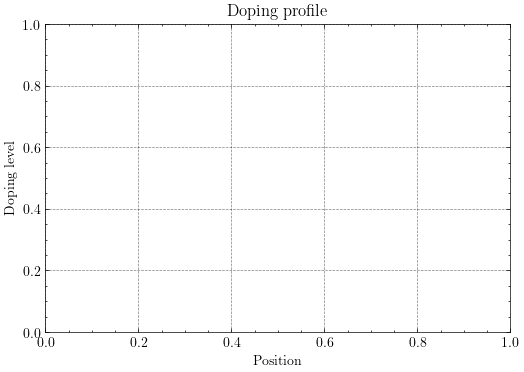

In [10]:
# Plot the doping profile of the first particle
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_xlabel("Position")
ax.set_ylabel("Doping level")

length_donor = X[0,0,0]
level_donor = X[0,0,1]
LevelAcc = X[0,0,2:]
Xacc = x_acc(length_donor, len(LevelAcc), 10)
ax.set_title("Doping profile")
x, y = plot_doping_profile(1.0, 5.0e19, Xacc, smooth(X[0,0,:]))
ax.plot(x, y, '.-', alpha=0.5, label="Position")
ax.set_yscale('log')


In [ ]:
IDX_PARTICLE = 2
DIR = "data/"
# Create the directory if it does not exist
if not os.path.exists(DIR):
    os.makedirs(DIR)


# Animation of the doping profile for the first particle
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.set_xlabel("Position")
ax.set_ylabel("Doping level")
ax.set_title("Doping profile")
ax.set_xlim(0, 10)
ax.set_ylim(1e12, 1e20)
ax.set_yscale('log')

list_lines = []
for i in range(NbPart):
    line, = ax.plot([], [], '-', alpha=0.9, lw=2, label="Doping profile")
    list_lines.append(line)

def init():
    for line in list_lines:
        line.set_data([], [])
    return list_lines

def animate(i):
    print(f"\rFrame {i} / {NbIter}", end="", flush=True)
    for j in range(NbPart):
        length_donor = X[i,j,0]
        level_donor = X[i,j,1]
        LevelAcc = X[i,j,2:]
        Xacc = x_acc(length_donor, len(LevelAcc), 10)
        x, y = plot_doping_profile(length_donor, 10**level_donor, Xacc, LevelAcc) 
        list_lines[j].set_data(x, y)
        # fig.savefig(f"{DIR}doping_profile_swarm_{i:04d}.pdf", dpi=300)
    return list_lines
    
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=NbIter, interval=100, blit=True, repeat=False)

anim.save('../build/doping_profile_swarm.mp4', fps=10, extra_args=['-vcodec', 'libx264'], dpi=300)

In [ ]:
# Quadriplot at 4 different itteration
iter0 = 0
iter1 = 10 
iter2 = 50
iter3 = 100

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(3.5, 4.0))

axs[0,0].set_title("Iteration: 0")
axs[0,1].set_title("Iteration: 10")
axs[1,0].set_title("Iteration: 50")
axs[1,1].set_title("Iteration: 100")

axs[1, 0].set_xlabel("Position ($\mu$m)")
axs[0, 0].set_ylabel("Net doping ($cm^{-3}$)")

# axs[0, 1].set_xlabel("Position ($\mu$m)")
axs[1, 0].set_ylabel("Net doping ($cm^{-3}$)")

axs[1, 1].set_xlabel("Position ($\mu$m)")

for ax_ in axs.flat:
    ax_.set_xlim(0, 10)
    ax_.set_ylim(3e13, 1e20)
    ax_.set_yscale('log')


for i in range(NbPart):
    length_donor = X[iter0,i,0]
    level_donor = X[iter0,i,1]
    LevelAcc = X[iter0,i,2:]
    Xacc = x_acc(length_donor, len(LevelAcc), 10)
    x, y = plot_doping_profile(length_donor, 10**level_donor, Xacc, LevelAcc)
    smoothed = convol_square(y, 5)
    axs[0,0].plot(x, smoothed, '-', alpha=0.8, label="Position")

    length_donor = X[iter1,i,0]
    level_donor = X[iter1,i,1]
    LevelAcc = X[iter1,i,2:]
    Xacc = x_acc(length_donor, len(LevelAcc), 10)
    x, y = plot_doping_profile(length_donor, 10**level_donor, Xacc, LevelAcc)
    smoothed = convol_square(y, 5)
    axs[0,1].plot(x, smoothed, '-', alpha=0.8, label="Position")

    length_donor = X[iter2,i,0]
    level_donor = X[iter2,i,1]
    LevelAcc = X[iter2,i,2:]
    Xacc = x_acc(length_donor, len(LevelAcc), 10)
    x, y = plot_doping_profile(length_donor, 10**level_donor, Xacc, LevelAcc)
    smoothed = convol_square(y, 5)
    axs[1,0].plot(x, smoothed, '-', alpha=0.8, label="Position")

    length_donor = X[iter3,i,0]
    level_donor = X[iter3,i,1]
    LevelAcc = X[iter3,i,2:]
    Xacc = x_acc(length_donor, len(LevelAcc), 10)
    x, y = plot_doping_profile(length_donor, 10**level_donor, Xacc, LevelAcc)
    smoothed = convol_square(y, 5)
    axs[1,1].plot(x, smoothed, '-', alpha=0.8, label="Position")

# fig.tight_layout()
plt.savefig('../build/doping_profile_swarm_quadriplot.pdf', dpi=300)



NameError: name 'plt' is not defined